In [81]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

## Dataset loading

In [3]:
base_dir = '/home/nur/Documents/Selise/dataset/dataset/'

In [4]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
print(train_dir)
print(test_dir)

/home/nur/Documents/Selise/dataset/dataset/train
/home/nur/Documents/Selise/dataset/dataset/test


## Data Augmentation and Generators

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255., 
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    batch_size = BATCH_SIZE, 
    class_mode = 'categorical', 
    target_size = TARGET_SIZE,
    subset = 'training')

Found 4800 images belonging to 4 classes.


In [8]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    target_size = TARGET_SIZE)

Found 1600 images belonging to 4 classes.


In [31]:
# val_generator = test_datagen.flow_from_directory(
#     test_dir, 
#     batch_size = BATCH_SIZE, 
#     class_mode = 'categorical', 
#     target_size = TARGET_SIZE,
#     subset = 'validation')

Found 0 images belonging to 4 classes.


## Loading the Base Model

In [38]:
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

94773248/94765736 [==============================] - 394s 4us/step


In [39]:
for layer in base_model.layers:
    layer.trainable = False

## build and compile the model

In [41]:
base_model = Sequential()

In [42]:
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(4, activation='softmax'))

In [45]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, epochs = 10)

Epoch 1/10
150/150 [==============================] - 9244s 62s/step - loss: 3.4624 - acc: 0.4923 - val_loss: 2.0004 - val_acc: 0.2850
Epoch 2/10
150/150 [==============================] - 9716s 65s/step - loss: 1.4331 - acc: 0.7294 - val_loss: 2.8237 - val_acc: 0.2219
Epoch 3/10
150/150 [==============================] - 9707s 65s/step - loss: 0.9858 - acc: 0.8040 - val_loss: 2.8478 - val_acc: 0.3919
Epoch 4/10
 22/150 [===>..........................] - ETA: 2:11:33 - loss: 0.7257 - acc: 0.8409

## VGG

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
base_model = VGG16(input_shape = (224, 224, 3),
                   include_top = False,
                   weights = 'imagenet')

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [14]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4, activation='softmax')(x)


model = tf.keras.models.Model(base_model.input, x)

In [15]:
model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

In [21]:
filepath="weights-improvement-{epoch:02d}-{acc:.2f}-{val_acc:.2f}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [22]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 5, callbacks=callbacks_list, verbose=1)

Epoch 1/5
20/20 [==============================] - ETA: 0s - loss: 1.2886 - acc: 0.3859 
Epoch 00001: val_loss improved from inf to 1.11463, saving model to weights-improvement-01-0.39-0.54-1.11.hdf5
20/20 [==============================] - 780s 39s/step - loss: 1.2886 - acc: 0.3859 - val_loss: 1.1146 - val_acc: 0.5425
Epoch 2/5
20/20 [==============================] - ETA: 0s - loss: 1.2223 - acc: 0.4391 
Epoch 00002: val_loss improved from 1.11463 to 1.09720, saving model to weights-improvement-02-0.44-0.57-1.10.hdf5
20/20 [==============================] - 787s 39s/step - loss: 1.2223 - acc: 0.4391 - val_loss: 1.0972 - val_acc: 0.5744
Epoch 3/5
20/20 [==============================] - ETA: 0s - loss: 1.2680 - acc: 0.4109 
Epoch 00003: val_loss improved from 1.09720 to 1.08406, saving model to weights-improvement-03-0.41-0.58-1.08.hdf5
20/20 [==============================] - 771s 39s/step - loss: 1.2680 - acc: 0.4109 - val_loss: 1.0841 - val_acc: 0.5781
Epoch 4/5
20/20 [============

In [30]:
with open('./trainHistoryDict', 'wb') as file_pi:
    pickle.dump(vgghist.history, file_pi)

In [29]:
dict(vgghist.history)

{'loss': [1.2885534763336182,
  1.222337007522583,
  1.2680213451385498,
  1.2570345401763916,
  1.2211029529571533],
 'acc': [0.38593751192092896,
  0.4390625059604645,
  0.41093748807907104,
  0.4296875,
  0.4281249940395355],
 'val_loss': [1.1146347522735596,
  1.0972046852111816,
  1.084061861038208,
  1.067854642868042,
  1.053179144859314],
 'val_acc': [0.5425000190734863,
  0.5743749737739563,
  0.578125,
  0.5962499976158142,
  0.6150000095367432]}

In [31]:
with open('./trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

In [32]:
history

{'loss': [1.2885534763336182,
  1.222337007522583,
  1.2680213451385498,
  1.2570345401763916,
  1.2211029529571533],
 'acc': [0.38593751192092896,
  0.4390625059604645,
  0.41093748807907104,
  0.4296875,
  0.4281249940395355],
 'val_loss': [1.1146347522735596,
  1.0972046852111816,
  1.084061861038208,
  1.067854642868042,
  1.053179144859314],
 'val_acc': [0.5425000190734863,
  0.5743749737739563,
  0.578125,
  0.5962499976158142,
  0.6150000095367432]}

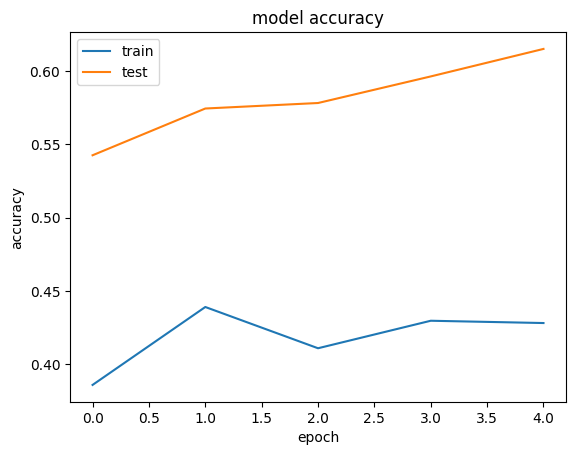

In [37]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

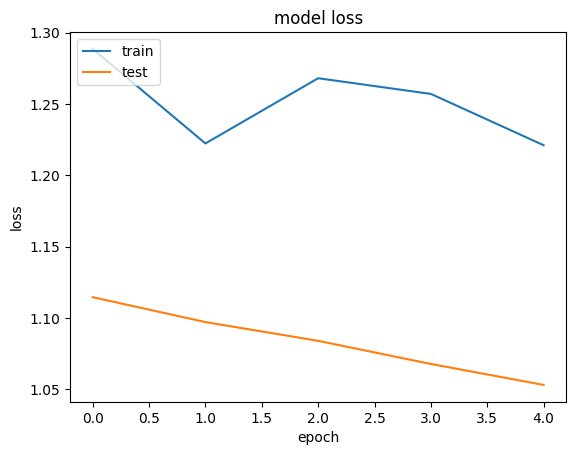

In [39]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Second

In [42]:
filepath="weights-improvement-{epoch:02d}-{acc:.2f}-{val_acc:.2f}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [43]:
vgghist2 = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 50, epochs = 5, callbacks=callbacks_list, verbose=1)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 1.1712 - acc: 0.4531 
Epoch 00001: val_loss improved from inf to 0.99620, saving model to weights-improvement-01-0.45-0.66-1.00.hdf5
50/50 [==============================] - 1300s 26s/step - loss: 1.1712 - acc: 0.4531 - val_loss: 0.9962 - val_acc: 0.6562
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 1.1419 - acc: 0.4787 
Epoch 00002: val_loss improved from 0.99620 to 0.97073, saving model to weights-improvement-02-0.48-0.67-0.97.hdf5
50/50 [==============================] - 1326s 27s/step - loss: 1.1419 - acc: 0.4787 - val_loss: 0.9707 - val_acc: 0.6712
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 1.1153 - acc: 0.4906 
Epoch 00003: val_loss improved from 0.97073 to 0.95061, saving model to weights-improvement-03-0.49-0.68-0.95.hdf5
50/50 [==============================] - 1297s 26s/step - loss: 1.1153 - acc: 0.4906 - val_loss: 0.9506 - val_acc: 0.6787
Epoch 4/5
50/50 [=========

In [44]:
with open('./trainHistoryDict2', 'wb') as file_pi:
    pickle.dump(vgghist2.history, file_pi)

## training 3

In [45]:
vgghist3 = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 50, epochs = 5, callbacks=callbacks_list, verbose=1)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 1.0620 - acc: 0.5412 
Epoch 00001: val_loss improved from 0.90602 to 0.89204, saving model to weights-improvement-01-0.54-0.72-0.89.hdf5
50/50 [==============================] - 1476s 30s/step - loss: 1.0620 - acc: 0.5412 - val_loss: 0.8920 - val_acc: 0.7206
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 1.0308 - acc: 0.5425 
Epoch 00002: val_loss improved from 0.89204 to 0.87370, saving model to weights-improvement-02-0.54-0.72-0.87.hdf5
50/50 [==============================] - 1362s 27s/step - loss: 1.0308 - acc: 0.5425 - val_loss: 0.8737 - val_acc: 0.7237
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 1.0474 - acc: 0.5419 
Epoch 00003: val_loss improved from 0.87370 to 0.86088, saving model to weights-improvement-03-0.54-0.73-0.86.hdf5
50/50 [==============================] - 1515s 30s/step - loss: 1.0474 - acc: 0.5419 - val_loss: 0.8609 - val_acc: 0.7294
Epoch 4/5
50/50 [=====

In [47]:
with open('./trainHistoryDict3', 'wb') as file_pi:
    pickle.dump(vgghist3.history, file_pi)

## training 4

In [48]:
vgghist4 = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 50, epochs = 5, callbacks=callbacks_list, verbose=1)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 0.9928 - acc: 0.5763 
Epoch 00001: val_loss improved from 0.83006 to 0.81428, saving model to weights-improvement-01-0.58-0.76-0.81.hdf5
50/50 [==============================] - 1194s 24s/step - loss: 0.9928 - acc: 0.5763 - val_loss: 0.8143 - val_acc: 0.7588
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 0.9944 - acc: 0.5725 
Epoch 00002: val_loss improved from 0.81428 to 0.80508, saving model to weights-improvement-02-0.57-0.75-0.81.hdf5
50/50 [==============================] - 1239s 25s/step - loss: 0.9944 - acc: 0.5725 - val_loss: 0.8051 - val_acc: 0.7538
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 0.9665 - acc: 0.5950 
Epoch 00003: val_loss improved from 0.80508 to 0.79366, saving model to weights-improvement-03-0.60-0.76-0.79.hdf5
50/50 [==============================] - 1586s 32s/step - loss: 0.9665 - acc: 0.5950 - val_loss: 0.7937 - val_acc: 0.7581
Epoch 4/5
50/50 [=====

In [51]:
with open('./trainHistoryDict4', 'wb') as file_pi:
    pickle.dump(vgghist4.history, file_pi)

## Combining all training history

In [53]:
with open('./training1/trainHistoryDict', "rb") as file_pi:
    training_hist1 = pickle.load(file_pi)

In [54]:
with open('./training2/trainHistoryDict2', "rb") as file_pi:
    training_hist2 = pickle.load(file_pi)

In [55]:
with open('./training3/trainHistoryDict3', "rb") as file_pi:
    training_hist3 = pickle.load(file_pi)

In [57]:
with open('./training4/trainHistoryDict4', "rb") as file_pi:
    training_hist4 = pickle.load(file_pi)

In [59]:
training = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': []
}

In [65]:
training['loss'] = training_hist1['loss'] + training_hist2['loss'] + training_hist3['loss'] + training_hist4['loss']

In [68]:
for key in training:
    training[key] = training_hist1[key] + training_hist2[key] + training_hist3[key] + training_hist4[key]

In [69]:
training

{'loss': [1.2885534763336182,
  1.222337007522583,
  1.2680213451385498,
  1.2570345401763916,
  1.2211029529571533,
  1.1712069511413574,
  1.1418930292129517,
  1.1152764558792114,
  1.099481225013733,
  1.0863689184188843,
  1.061973214149475,
  1.0307618379592896,
  1.047385573387146,
  1.0144274234771729,
  1.0054130554199219,
  0.9928168654441833,
  0.994356632232666,
  0.9664849042892456,
  0.9303587079048157,
  0.9368295073509216],
 'acc': [0.38593751192092896,
  0.4390625059604645,
  0.41093748807907104,
  0.4296875,
  0.4281249940395355,
  0.453125,
  0.47874999046325684,
  0.4906249940395355,
  0.5074999928474426,
  0.5162500143051147,
  0.5412499904632568,
  0.5425000190734863,
  0.5418750047683716,
  0.5587499737739563,
  0.5724999904632568,
  0.5762500166893005,
  0.5724999904632568,
  0.5950000286102295,
  0.6000000238418579,
  0.6100000143051147],
 'val_loss': [1.1146347522735596,
  1.0972046852111816,
  1.084061861038208,
  1.067854642868042,
  1.053179144859314,
  0.9

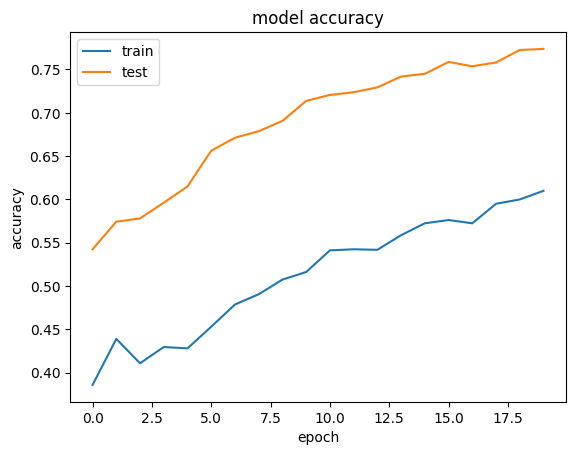

In [70]:
plt.plot(training['acc'])
plt.plot(training['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

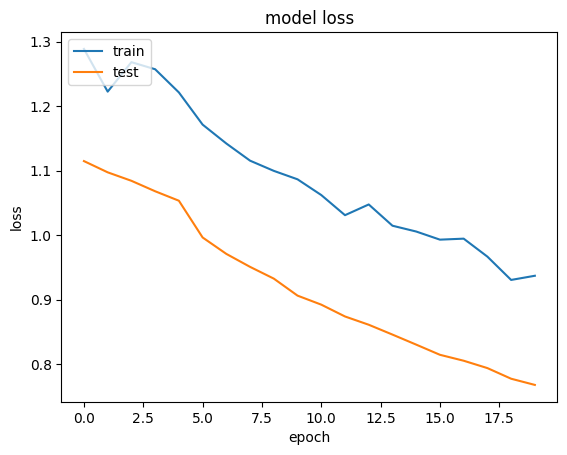

In [71]:
plt.plot(training['loss'])
plt.plot(training['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [73]:
model.save('./saved_model')

INFO:tensorflow:Assets written to: ./saved_model/assets


## Loading model

In [74]:
saved_model = tf.keras.models.load_model('./saved_model')


In [75]:
image_path = './dataset/dataset/test/bird/1_256.jpg'

In [85]:
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))

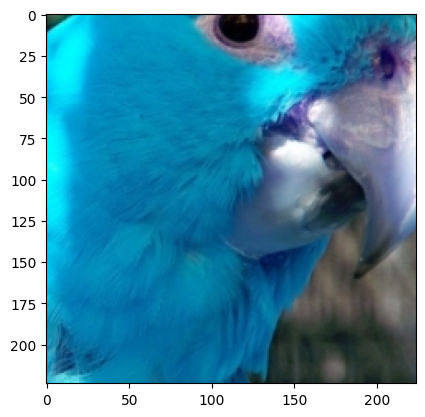

In [86]:
plt.imshow(image)
plt.show()

In [88]:
image_expand = np.expand_dims(image, axis=0)

In [89]:
saved_model.predict(image_expand)

array([[6.3368351e-09, 6.6238612e-15, 1.0000000e+00, 3.9612612e-18]],
      dtype=float32)

In [90]:
print(train_generator.class_indices)

{'berry': 0, 'bird': 1, 'dog': 2, 'flower': 3}
